**Key Terms**

- **One-hot encoding:**
    The process of transforming a categorical variable into dichotomous indicator variables so that the data is numeric
- **Indicator variable:**
    Also called a dummy variable, a dichotomous variable that indicates the presence or absence of a given qualitative variable
- **Box-Cox transformation:**
    A transformation designed to transform data to resemble a normal distribution
- **Normalization:**
    The process of rescaling variables into the [0,1] range
- **Standardization:**
    The process of rescaling a variable to have a mean of zero and a standard deviation of one

Now that you have cleaned your data and explored it, the next step is to identify which features you think would be useful in explaining the target variable. This step is called *feature engineering*. In this lesson, you'll learn about how you should approach feature engineering and what kind of techniques you can use.

In this step of the EDA process, you need to transform your variables into features. You call the variables *features* if you think that they are well suited to work within your model to explain the target variable. Feature engineering is the process of selecting or modifying the existing variables and creating new ones to be used in your models. Feature engineering is [a broad and complex topic](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) and an opportunity to get creative with your data. Throughout this lesson, you'll explore how to pare down a set of features into the best ones for your problem. The figure below shows where you are in the general EDA process:

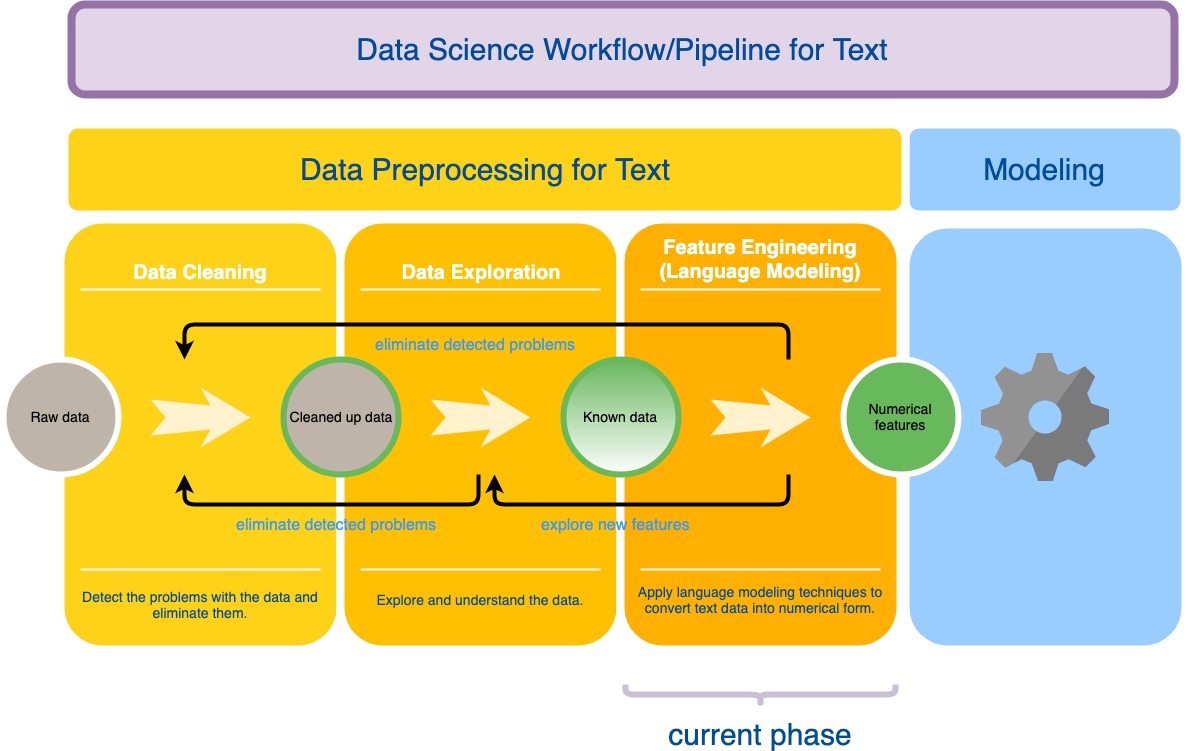
As emphasized in the previous lessons, EDA is an iterative process. Whenever you encounter a problem with your data in the feature-engineering phase, you need to go back and eliminate the problem. By the same token, when you modify a variable or create a new one, you need to apply data-exploration techniques to understand whether your new variable is useful or not. Like before, there are examples in this lesson to illustrate the techniques. But keep in mind that feature engineering is a wide domain. When you are working with your data, don't limit yourself to what you see–try anything that you think will highlight a particular feature within your dataset.

You'll explore feature engineering in three steps:

1. Transforming the existing variables
2. Creating new variables
3. Selecting the features

You will focus on the first and second steps in this lesson, and you'll learn about the third step in the next lesson.

## Transforming the existing variables

There are many reasons that existing variables may need to be transformed. Here are some key reasons:

- Machine-learning models can only work with numeric variables. So, categorical variables that have text values need to be converted to numeric values.
- Some machine-learning models assume that the target variable is normally distributed. To use these models, you may need to transform your target to be normally distributed.
- Some machine-learning models are very sensitive to the relative magnitude of values. So, you may need to limit the values of the variables to some fixed range. Usually, you do this by normalizing your variables.
- To improve your intuition and your understanding of the data, you may want to transform variables to a different unit of measurement.

Below, you'll work through examples of each case.

### Working with categorical variables

Because most models require that all data be numeric, you'll usually need to convert your string-based categorical data in order to use it. One method for this purpose is called *one-hot encoding*. In one-hot encoding, to get the information from a categorical variable with $X$ levels, you create $X-1$ numeric features, each of which is coded `1` or `0`. The resulting variables that take `0` or `1` for each category are known as *dummy* or *indicator* variables. To apply one-hot encoding to a categorical variable, you can use the pandas `get_dummies()` function.

Consider the YouTube dataset. The variable `Grade` is categorical, taking the values `A++`, `A+`, `A`, `A-`, `B+`. Although the `Grade` variable has five levels, only four features are needed to represent all of the information. Why four? Well, if you know that the values for `A++`, `A+`, `A`, and `A-` are `0`, then you also know that the value for `B+` must be `1`. This level without a feature is called the *reference value*.

Now, load your YouTube dataset and create dummy variables for the `Grade` variable:

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine, text
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# youtube_df = pd.read_sql_query('select * from youtube',con=engine)
with engine.begin() as conn:
    query = text("""SELECT * FROM youtube""")
    youtube_df = pd.read_sql_query(query, conn)


# No need for an open connection,
# because you're only doing a single query
engine.dispose()

# You're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# Apply one-way winsorization to the highest end
# of the value distribution. Because you have a lot of extreme
# values, set the values of the outliers to the
# value of the ninetieth percentile.
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]

# One-hot encoding the `Grade` variable:
pd.get_dummies(youtube_df["Grade"])

,A,A+,A++,A-,B+
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
4995,0,0,0,0,1
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


Notice that the `get_dummies()` function returned one dummy variable for each category by naming the dummies in reference to the values of the `Grade` variable. However, for the reasons explained above, you ought to exclude one of the variables from dummy coding when you include them in a model.

If you're worried that you'll forget this, you can set the `drop_first` parameter of `get_dummies()` to `True`. This will exclude the first category from dummy coding.

Also, keep in mind that just calling `pd.get_dummies(youtube_df["Grade"])` won't store the dummies in the DataFrame. To append them to the DataFrame, use `pd.concat()`. The `axis = 1` parameter will concatenate the two DataFrames along the column, as demonstrated below:

In [3]:
# Append dummies to the YouTube DataFrame
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views,A,A+,A++,A-,B+
0,1st,A++,Zee TV,82757.0,18752951.0,20869786591,5653.0,5895361.0,2468241402,0,0,1,0,0
1,2nd,A++,T-Series,12661.0,61196302.0,47548839843,5653.0,5895361.0,2468241402,0,0,1,0,0
2,3rd,A++,Cocomelon - Nursery Rhymes,373.0,19238251.0,9793305082,373.0,5895361.0,2468241402,0,0,1,0,0
3,4th,A++,SET India,27323.0,31180559.0,22675948293,5653.0,5895361.0,2468241402,0,0,1,0,0
4,5th,A++,WWE,36756.0,32852346.0,26273668433,5653.0,5895361.0,2468241402,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"4,996th",B+,Uras Benlioğlu,706.0,2072942.0,441202795,706.0,2072942.0,441202795,0,0,0,0,1
4996,"4,997th",B+,HI-TECH MUSIC LTD,797.0,1055091.0,377331722,797.0,1055091.0,377331722,0,0,0,0,1
4997,"4,998th",B+,Mastersaint,110.0,3265735.0,311758426,110.0,3265735.0,311758426,0,0,0,0,1
4998,"4,999th",B+,Bruce McIntosh,3475.0,32990.0,14563764,3475.0,32990.0,14563764,0,0,0,0,1


### Dealing with non-normality

As mentioned before, many machine-learning models assume the target variable to be normally distributed. Fortunately, non-normal variables can sometimes be transformed into normally distributed features using transformations such as taking the square root, the inverse, or the log of the variable. These variables can also be handled by applying the Box-Cox transformation.

As you may remember, you already touched upon these techniques in the lesson about data cleaning and outliers. Applying transformations, such as a log transformation, does more than just help with outliers. It also affects the variable's distribution.

In the previous lesson about univariate analysis, you used histograms to visualize continuous variables in the YouTube dataset. Repeat that process here:

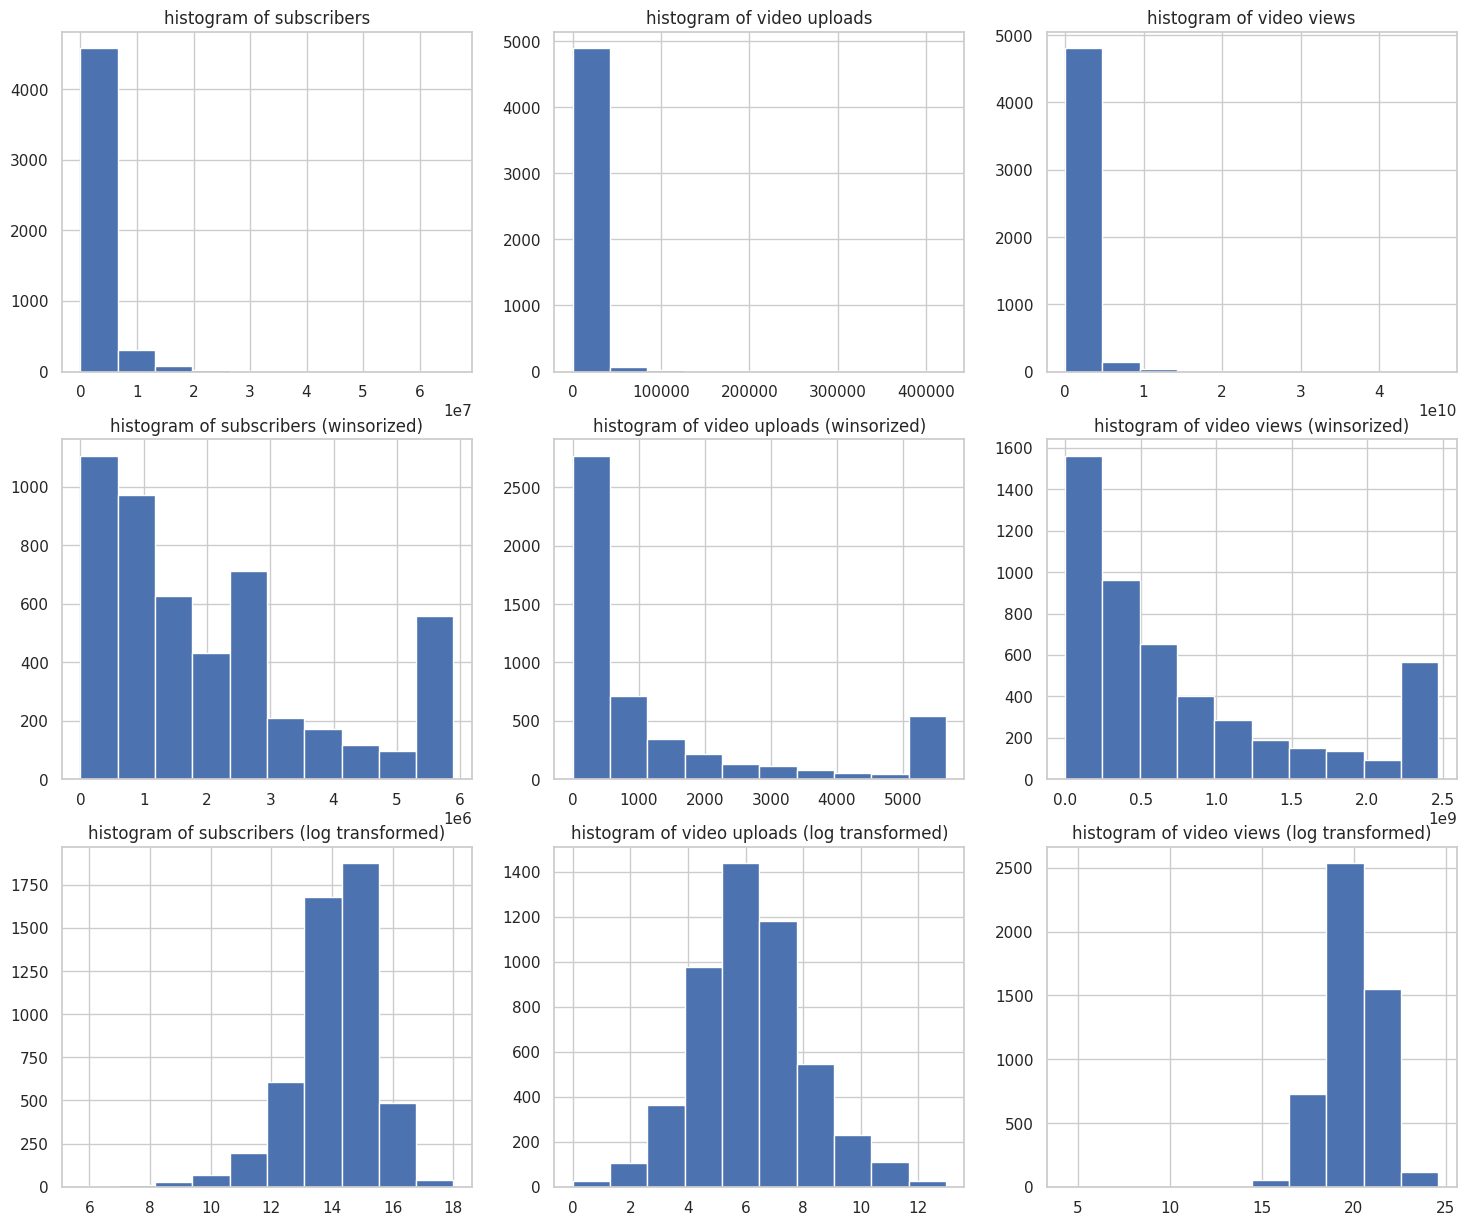

In [4]:
plt.figure(figsize=(18,15))

# Histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(youtube_df["Subscribers"])
plt.title("histogram of subscribers")

plt.subplot(3, 3, 2)
plt.hist(youtube_df["Video Uploads"])
plt.title("histogram of video uploads")

plt.subplot(3, 3, 3)
plt.hist(youtube_df["Video views"])
plt.title("histogram of video views")

# Histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("histogram of subscribers (winsorized)")

plt.subplot(3, 3, 5)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("histogram of video uploads (winsorized)")

plt.subplot(3, 3, 6)
plt.hist(youtube_df["winsorized_views"])
plt.title("histogram of video views (winsorized)")

# Histograms of the log-transformed data
plt.subplot(3, 3, 7)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("histogram of subscribers (log transformed)")

plt.subplot(3, 3, 8)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("histogram of video uploads (log transformed)")

plt.subplot(3, 3, 9)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("histogram of video views (log transformed)")


plt.show()

It appears that taking the logs of the three variables above transformed the distributions of the variables so that they more closely resemble the normal distribution. However, they are not *exactly* normally distributed.

You can statistically verify that the distributions of the log-transformed variables still don't follow the normal distribution by using the *Jarque-Bera test* and the *normality test* from SciPy, as demonstrated in the following code:

In [12]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
norm_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
norm_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
norm_stats = normaltest(np.log(youtube_df["Video views"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3650.193765441968 and p value is 0.0
Normality test statistics is 1168.7818668960138 and p value is 1.593097401471267e-254
Jarque-Bera test statistics is 83.01322878478949 and p value is 9.416866354547223e-19
Normality test statistics is 71.51140832706204 and p value is 2.9613857701554496e-16
Jarque-Bera test statistics is 7862.317134052271 and p value is 0.0
Normality test statistics is 1180.823167194929 and p value is 3.8681846024387925e-257


The p-values are `0`, which indicates that the distribution of the log-transformed variables is statistically different from the normal distribution. However, these transformations might still be useful. In general, working with distributions that "look" normal (with two tails on the left and right and a clustering of values around the mean) is easier than working with one-tailed distributions. Even so, some models only require multivariate normality, which can be achieved more easily using these kinds of distributions. So if you see that the distribution of a variable more closely resembles the normal distribution after a transformation, it could still be helpful even if it's not *exactly* normal.

Another common method to make variables normally distributed is the *Box-Cox transformation*. Applying this transformation is pretty easy using SciPy's `boxcox()` function from the `stats` module.

Our `boxcox()` function will return two separate pieces of output: the transformed array, and something called *lambda* which you can read more about in the [`scipy` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html). We are only interested in keeping the transformed array, so each time the function is run we'll simply save the second element as `_`.

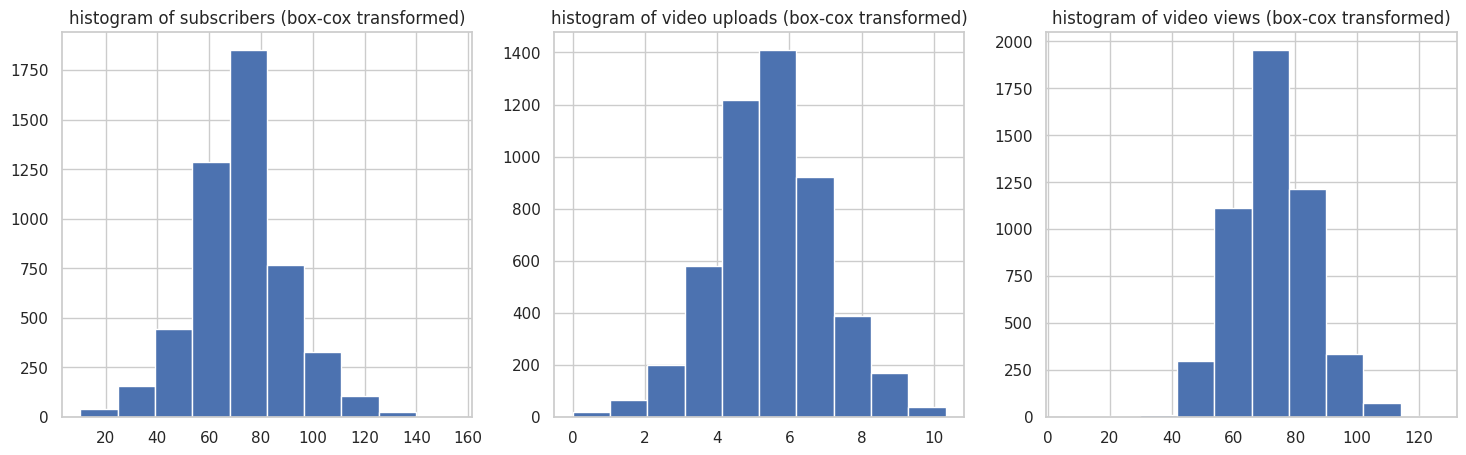

In [6]:
from scipy.stats import boxcox

# Save the transformed array, then the lambda as variable name and _ respectively
video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# Histograms of the Box-Cox-transformed data
plt.subplot(1, 3, 1)
plt.hist(subscribers_boxcox)
plt.title("histogram of subscribers (box-cox transformed)")

plt.subplot(1, 3, 2)
plt.hist(video_uploads_boxcox)
plt.title("histogram of video uploads (box-cox transformed)")

plt.subplot(1, 3, 3)
plt.hist(video_views_boxcox)
plt.title("histogram of video views (box-cox transformed)")

plt.show()

The histograms above resemble the normal distribution quite well, although they are still not quite normally distributed. You can confirm this using the Jarque-Bera and normality tests:

In [7]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(subscribers_boxcox)
norm_stats = normaltest(subscribers_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_uploads_boxcox)
norm_stats = normaltest(video_uploads_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_views_boxcox)
norm_stats = normaltest(video_views_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 112.35225936971695 and p value is 4.008822831501084e-25
Normality test statistics is 64.41977780861806 and p value is 1.0266513584521004e-14
Jarque-Bera test statistics is 32.00437101780299 and p value is 1.1228949665676423e-07
Normality test statistics is 23.235963339562396 and p value is 9.0027392143869e-06
Jarque-Bera test statistics is 93.4064116324942 and p value is 5.212612327994373e-21
Normality test statistics is 55.77146378439329 and p value is 7.751406546166845e-13


The Jarque-Bera and normality tests help indicate if the Box-Cox transformation resulted in a normal distribution. As with all statistical testing, the results can be considered significant if the p-value is less than a specified alpha level (most commonly `0.05`). Therefore, you can see that applying the Box-Cox transformation resulted in statistically normal distributions some of the time, but not in all cases. If the p-values for both the Jarque-Bera test and the normality test are smaller than `0.05` (such as `0.0`), you can assume that the transformation did not result in normally distributed data.

Note that Box-Cox, log, and square-root transformations only work when all data points are positive.

### Normalization and standardization

Some statistical techniques, such as principal components analysis (which you'll explore in the next lesson) and machine-learning models assume that all features have values in the same range (for example, a min of `0` and a max of `1`) or they exhibit normal statistical properties. For some techniques, features that vary in range can result in incorrect estimates and results. To be able to apply these techniques and methods, you'll need to rescale your variables to fit a limited range or standardize your variables to exhibit some regular statistical patterns.

In this lesson, you'll learn about two concepts of rescaling: *normalization* and *standardization*.

1. Normalization is the rescaling of a variable into the `[0,1]` range (including `0` and `1`). For this purpose, you'll use scikit-learn's `normalize()` method from the preprocessing module.
2. Standardization is the rescaling of a variable so that its mean becomes `0` and its standard deviation becomes `1`. Notice that in standardization, you don't apply a maximum value for the variable. To apply standardization, you'll use scikit-learn's `scale()` method from the preprocessing module.

If this is your first time using scikit-learn, you'll need to call `pip install sklearn` from  your command line to install the package.

Take a look at the process for normalizing the winsorized versions of the continuous variables in the YouTube dataset:

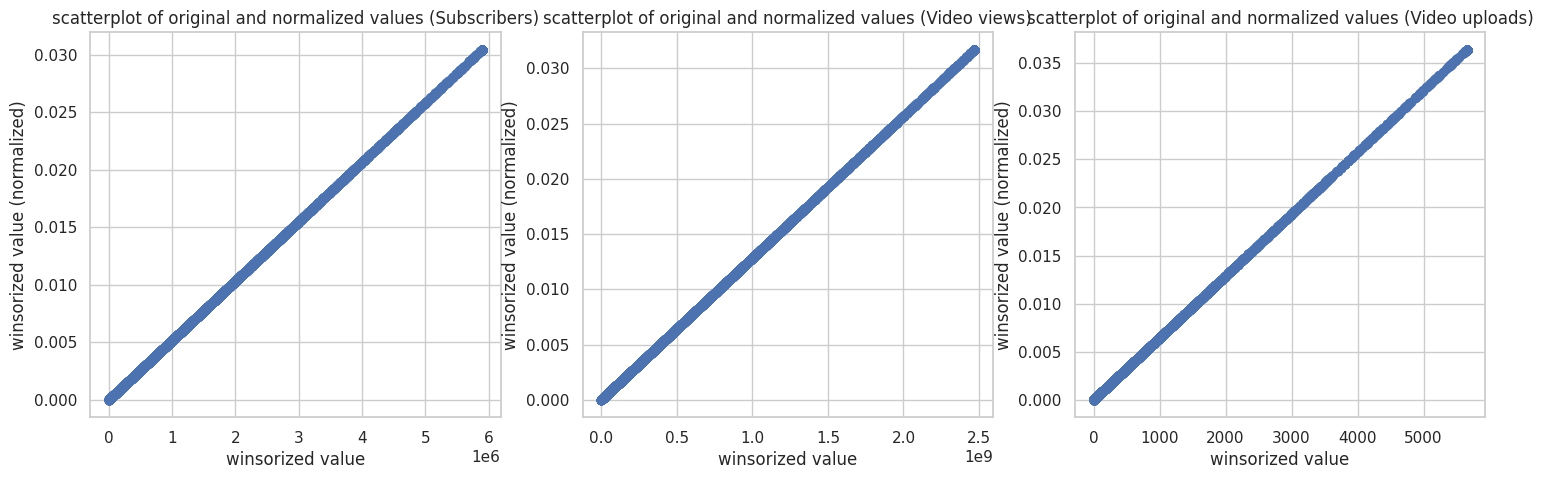

In [8]:
from sklearn.preprocessing import normalize

# Normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("scatterplot of original and normalized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,2)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("scatterplot of original and normalized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,3)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("scatterplot of original and normalized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.show()

This time, standardize the variables:

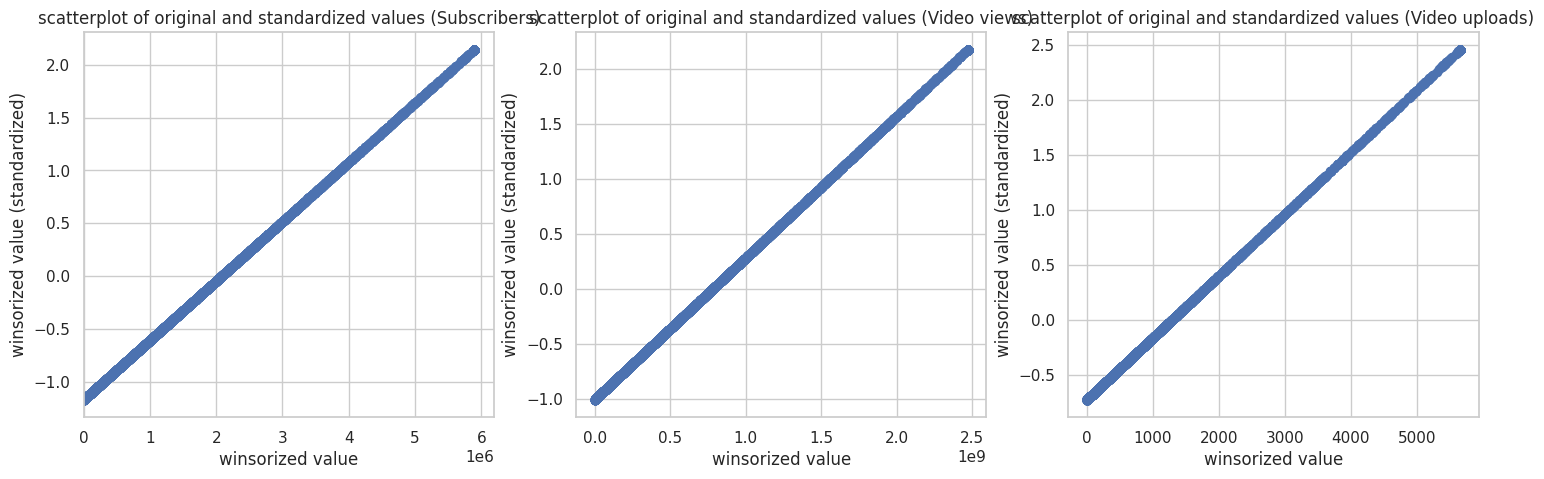

In [9]:
from sklearn.preprocessing import scale

youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("scatterplot of original and standardized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("scatterplot of original and standardized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.subplot(1,3,3)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("scatterplot of original and standardized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.show()


Transforming variables for ease of understanding and interpretation is a common practice. For example, if the research question is formulated in terms of centimeters but a variable is measured in feet, you can convert the variable to centimeters. Or, even better, you can create a new variable in terms of a neutral unit of measurement, such as standard deviations.

Transforming variables is also common in time series data. In finance, for example, you usually care about the change in a stock price over the course of time rather than its level. Similarly, you usually measure the change in the economic activity from quarter to quarter, rather than the level of the activity in each quarter. In those kinds of cases, if you have variables that only measure the levels, you may want to transform them to changes.

You can also recode a variable to make a feature that matches the terminology of the research question. For example, if your research question involves measuring sadness, it will be easier to interpret your results if any variables put in terms of happiness are reverse-coded so that the scores are in the same "direction" as the research question.


## Creating new variables

Sometimes, you may want to define new features that you believe will be useful in explaining the target variable. If that statement sounds general, it is—because the only limit here is your own creativity.

Here's an example: Say that you have a variable called `name` in your dataset. This variable has values like `Mr. Adam Smith`, `Sir Anthony Hopkins`, `Queen Elizabeth`, `Papa James Hetfield`, and so forth. This is text data, and as such, it's hard to use in a model. But, with the help of your imagination, you can derive a useful feature from it. By deriving titles like `Mr.`, `Sir`, `Queen`, or `Papa` from the names, you can determine the gender of the person and create a new feature called `gender`. You can also try to imagine what you can do with a variable that holds the full addresses of the people.

As you may imagine, this topic is very broad. So here are a few common use cases that you may find useful when working with continuous variables:

1. **Combining two or more highly correlated variables:** Many models assume that features are correlated with the outcome but uncorrelated with each other. Two highly correlated variables can be averaged to create a feature, or one can be dropped. Three or more highly correlated variables can also be combined using a statistical method called *principal components analysis* (PCA) that reduces the correlated set of variables into a smaller set of uncorrelated features. You'll go through an in-depth introduction to PCA in the next lesson.

2. **Interactions of variables:** If you suspect that the relationship between the outcome and a feature depends on the value of a second feature, you may want to create a feature that represents the interaction between them. Say, for example, that watching more TV only makes people sad if they do it alone. People who live with a partner are probably less likely to watch TV alone. To represent the concept that people who live with a romantic partner don't get sad watching TV but that people who don't live with a romantic partner do get sad, you can multiply your `partner` indicator by the `sadness` feature to create the interaction.

3. **Creating linear relationships:** Many models assume that the relationship between a feature and an outcome is linear. But at times, you'll want to include a variable that has a nonlinear component to its relationship with the outcome. To capture nonlinearity while satisfying the model's assumptions, it can be helpful to create quadratic or higher-level features by squaring, cubing, or otherwise multiplying a variable by itself.